# L665 ML for NLPSpring 2018 

## Assignment 2 - Task 1 

Author: Carlos Sathler

In [1]:
import numpy as np
import nltk

import matplotlib.pyplot as plt
%matplotlib inline  

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from nltk.corpus import brown
nltk.download('brown')
nltk.download('universal_tagset')

Using TensorFlow backend.


[nltk_data] Downloading package brown to /Users/carlos2/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/carlos2/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [2]:
%%time

# create lists of tokens and tags from corpora
# add UNK to map unknown tag values, PAD to pad sequences for RNN
tokens, tags = zip(*brown.tagged_words())
tokens = list(tokens)
tokens.append('PAD')
tags = list(tags)
tags.append('PAD')

# create token embedding dictionary and inverse dictionary
token_dict = {token: no for no, token in enumerate(set(tokens))}
token_dict_inv = {no: token for token, no in token_dict.items()}

# create tag embedding dictionary and inverse dictionary
tag_dict = {tag: no for no, tag in enumerate(set(tags))}
tag_dict_inv = {no: tag for tag, no in tag_dict.items()}

# Create dictionary with sentence number as key, 
# and tuple with lists of token, token numbers, tags, tag numbers  

sents = {}
start = 0
for sent_no, token_list in enumerate(brown.sents()):
    end = start + len(token_list)
    # get tags for this sentence, and then embedding
    sent_tokens = tokens[start: end]
    token_nos   = [token_dict[token] for token in sent_tokens]
    sent_tags   = tags[start: end]
    tag_nos     = [tag_dict[tag] for tag in sent_tags]
    sents[sent_no] = (tokens, token_nos, tags, tag_nos)
    start = end

# determine len of longer sentence
token_seqs = [sents[1][1] for sents in sents.items()]
tag_seqs = [sents[1][3] for sents in sents.items()]

CPU times: user 10.6 s, sys: 482 ms, total: 11.1 s
Wall time: 11.4 s


In [3]:
print('Number of pos tags: {}\n'.format(len(tag_dict_inv)))
print('List of tags: {}'.format(tag_dict_inv.values()))

Number of pos tags: 473

List of tags: dict_values(['OD', 'UH-HL', 'WDT+BER+PP', 'NP+BEZ', 'PN+MD', 'NN+IN', 'PPL-NC', 'NPS$-HL', '*-HL', 'PPS-NC', 'MD+PPSS', 'PPS+BEZ-NC', 'JJ', 'FW-PPSS', 'NN-TL', 'CS-HL', 'NR-HL', 'RP', 'WRB+BEZ-TL', ',-HL', 'WRB+IN', 'UH-TL', 'FW-PPL+VBZ', 'NNS', 'FW-NPS-TL', 'VBD', 'NP-HL', 'NN$', 'FW-DT', 'QL-HL', 'QLP', 'BEDZ', 'AP-NC', 'EX-NC', 'NNS+MD', 'PPSS-TL', 'VBN+TO', 'RP-TL', 'DO-TL', 'FW-OD-NC', 'RN', 'DOZ-HL', 'WDT-HL', 'WRB+MD', 'FW-NN-TL', '*', 'JJS-HL', 'NNS-TL-NC', 'NNS$-HL', 'DT-TL', ')-HL', ',-TL', 'ABN-TL', 'NNS$', 'NN$-HL', 'IN-HL', 'JJ-TL', 'WRB+DO', 'PP$-TL', 'RB', 'PPSS+MD', 'FW-NNS-TL', 'WDT+DO+PPS', 'FW-NN-TL-NC', 'FW-AT-HL', 'VBN', 'NN+MD', 'PPL-TL', 'VBN-HL', 'NP$', 'MD*', 'FW-CC-TL', 'BER-HL', 'JJS-TL', 'FW-VBZ', 'VBN-TL-NC', ',-NC', 'DO', 'BER-NC', 'PPLS', 'IN-NC', 'AP', 'DTX', 'FW-PPL', 'OD-HL', 'AT-NC', 'NP$-HL', 'AP-TL', 'FW-IN+AT-TL', 'WRB+BEZ', 'VBG-NC', 'EX-HL', 'JJT-TL', 'WPS+BEZ', "''", 'RB-HL', 'VBG-TL', 'WRB-NC', 'PPO-TL', '

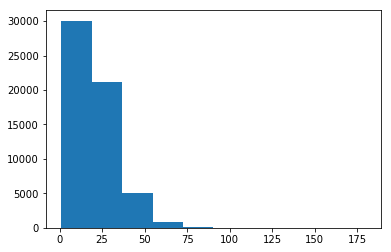

In [4]:
# visualize length of sentences
sentence_lengths = [len(seq) for seq in token_seqs]
_ = plt.hist(sentence_lengths)

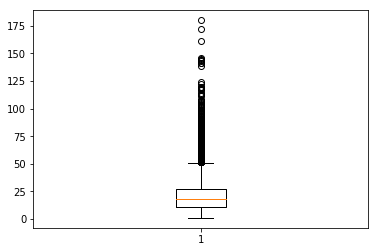

In [5]:
_ = plt.boxplot(sentence_lengths)

In [6]:
# will set MAX_SEQ to reasonable value based on distribution of sentence lengths
# this will help better evaluate accuracy of our model
MAX_SEQ = 45

# pad token and tag sequences to MAX_SEQ with PAD to get X and y for sequence to sequence model
X = pad_sequences(maxlen=MAX_SEQ, sequences=token_seqs, padding="pre", value=token_dict['PAD'])
y = pad_sequences(maxlen=MAX_SEQ, sequences=tag_seqs, padding="pre", value=tag_dict['PAD'])

In [7]:
# check if X and y were properly created
print(X[10])
print(y[10])

[ 6645  6645  6645  6645  6645  6645  6645  6645  6645  6645  6645  6645
  6645  6645  6645  6645  6645  6645  6645  6645  6645  6645  6645  6645
  6645  6645  6645  6645  6645  6645  6645 38409 46952 52892 27703 20272
 21646 28044  1593 11680 40684 10718 22115 24849 53671]
[264 264 264 264 264 264 264 264 264 264 264 264 264 264 264 264 264 264
 264 264 264 264 264 264 264 264 264 264 264 264 264 272  25 159 252 437
 352 220  23 189 220  94 414 437  99]


In [8]:
# define LSTM bidirectional seq to seq model
# will vectorize word embeddings to vectors of size wordvec_dim

WORDVEC_DIM = 20

def get_model(max_seq, voc_size, wordvec_dim, tag_count):
    
    input = Input(shape=(max_seq,), dtype='float64')
    embed = Embedding(input_dim=voc_size, output_dim=wordvec_dim, input_length=MAX_SEQ, \
                      embeddings_initializer='uniform')(input)
    #drop = Dropout(0.5)(embed)
    #lstm = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(embed)
    lstm = Bidirectional(LSTM(units=100, return_sequences=True))(embed)
    out = TimeDistributed(Dense(tag_count, activation="softmax"))(lstm) 

    model = Model(input, out)
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

    model.summary()
    
    return model

In [9]:
vocabulary_size = len(token_dict)
number_of_classes = len(tag_dict)

# need to change y to categorical 
ycat = [to_categorical(i, num_classes=number_of_classes) for i in y]

# reserve 10% of the dataset for testing after training the model
X_train, X_test, y_train, y_test = train_test_split(X, ycat, test_size=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 45)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 45, 20)            1121160   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 45, 200)           96800     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 45, 473)           95073     
Total params: 1,313,033
Trainable params: 1,313,033
Non-trainable params: 0
_________________________________________________________________
Train on 36124 samples, validate on 15482 samples
Epoch 1/10
36124/36124 [==============================] - 155s 4ms/step - loss: 0.9272 - acc: 0.7775 - val_loss: 0.3488 - val_acc: 0.9130
Epoch 2/10
36124/36124 [==============================] - 140s 4ms/step - lo

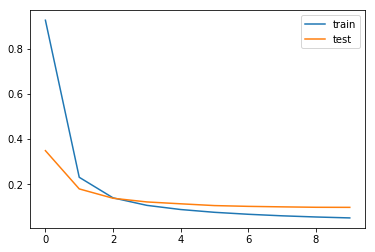

In [10]:
model = get_model(MAX_SEQ, vocabulary_size, WORDVEC_DIM, number_of_classes)

history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=10, validation_split=0.3, verbose=1,\
                    callbacks=[EarlyStopping(patience=2, monitor='val_loss')])

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')   
plt.legend()
plt.show()

In [11]:
y_hat = model.predict(X_test)
acc = accuracy_score(np.argmax(np.array(y_test), axis=-1).flatten(), np.argmax(y_hat, axis=-1).flatten())
print('Accuracy on test partition: {}'.format(acc))

Accuracy on test partition: 0.9763864666899198


In [12]:
y_hat = model.predict(X_test[10].reshape(-1,MAX_SEQ))
print('Prediction:')
print(np.argmax(y_hat, axis=-1).flatten())
print('True values:')
print(np.array(np.argmax(np.array(y_test[10]), axis=-1).flatten()))

Prediction:
[264 264 264 264 264 264 264 264 264 264 264 264 264 264 264 264 264 264
 264 159 283 252 437 163 252 437  23 163 437 163  12 437  23 453 252 348
  23 464  59  65 163 252  12 437  99]
True values:
[264 264 264 264 264 264 264 264 264 264 264 264 264 264 264 264 264 264
 264 159 283 252 437 163 252 437  23 163 437 163  12 437  23 453 252 348
  23 464  59  65 163 252  12 437  99]
